In [62]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [63]:
df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [64]:
x = df.drop(columns=['target'])
y = df['target']

print("X shape:- ", x.shape)
print("Y shape:- ", y.shape)

X shape:-  (303, 13)
Y shape:-  (303,)


In [65]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

print("X_train = \n", x_train)
print("\nX_test = \n", x_test)
print("\nY_train = \n", y_train)
print("\nY_train = \n", y_test)

X_train = 
      age  sex  cp  trestbps  chol  ...  exang  oldpeak  slope  ca  thal
47    47    1   2       138   257  ...      0      0.0      2   0     2
60    71    0   2       110   265  ...      0      0.0      2   1     2
94    45    0   1       112   160  ...      0      0.0      1   0     2
218   65    1   0       135   254  ...      0      2.8      1   1     3
132   42    1   1       120   295  ...      0      0.0      2   0     2
..   ...  ...  ..       ...   ...  ...    ...      ...    ...  ..   ...
11    48    0   2       130   275  ...      0      0.2      2   0     2
258   62    0   0       150   244  ...      1      1.4      1   0     2
266   55    0   0       180   327  ...      1      3.4      1   0     2
22    42    1   0       140   226  ...      0      0.0      2   0     2
291   58    1   0       114   318  ...      0      4.4      0   3     1

[227 rows x 13 columns]

X_test = 
      age  sex  cp  trestbps  chol  ...  exang  oldpeak  slope  ca  thal
156   47    1  

In [66]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(x_train,y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

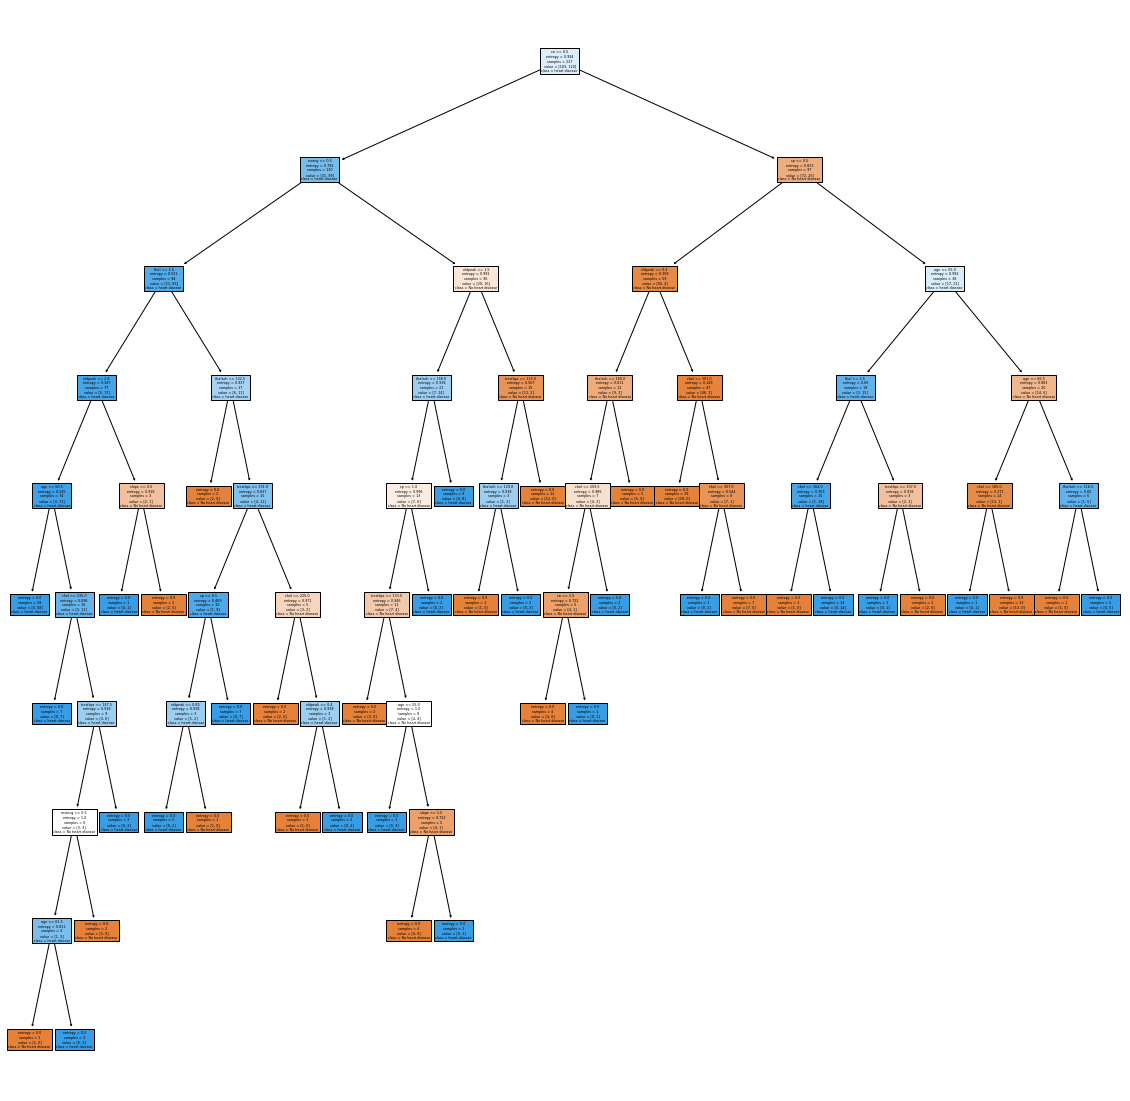

In [67]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['No heart disease', 'heart disease']

tree.plot_tree(clf,
               feature_names=features,
               class_names=classes,
               filled=True)
plt.show()

In [68]:
def plot_confusion_matrix(y_train_pred, y_train, dom):
  print(f'\n{dom} Confusion matrix')
  cf = confusion_matrix(y_train_pred, y_train)
  sns.heatmap(cf, annot=True, yticklabels=classes,
              xticklabels=classes,
              cmap="Blues",
              fmt='g')
  plt.tight_layout()
  plt.show()

Train Accuracy score 1.0
Test Accuracy score 0.7105263157894737

Train Confusion matrix


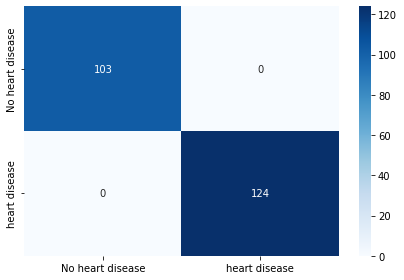


Test Confusion matrix


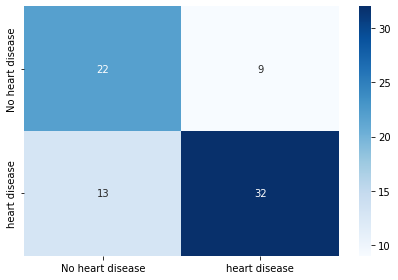

In [69]:
print(f'Train Accuracy score {accuracy_score(y_train_pred,y_train)}')
print(f'Test Accuracy score {accuracy_score(y_test_pred,y_test)}')
plot_confusion_matrix(y_train_pred,y_train,dom='Train')
plot_confusion_matrix(y_test_pred,y_test,dom='Test')

## **1. Pre-Pruning Techniques**

In [70]:
params = {'max_depth': [2,4,6,8,10,12],
          'min_samples_split': [2,3,4],
          'min_samples_leaf':[1,2]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf, param_grid=params)
gcv.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

Train Accuracy  score 0.9118942731277533
Test Accuracy  score 0.7368421052631579

Train Confusion matrix


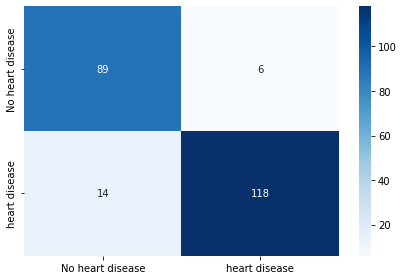


Test Confusion matrix


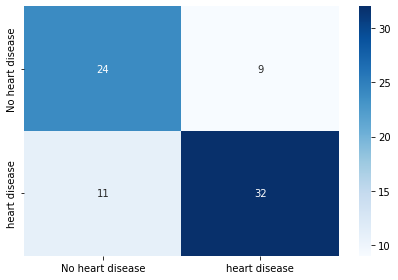

In [71]:
model=gcv.best_estimator_
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print(f'Train Accuracy  score {accuracy_score(y_train_pred,y_train)}')
print(f'Test Accuracy  score {accuracy_score(y_test_pred,y_test)}')
plot_confusion_matrix(y_train_pred,y_train,dom='Train')
plot_confusion_matrix(y_test_pred,y_test,dom='Test')

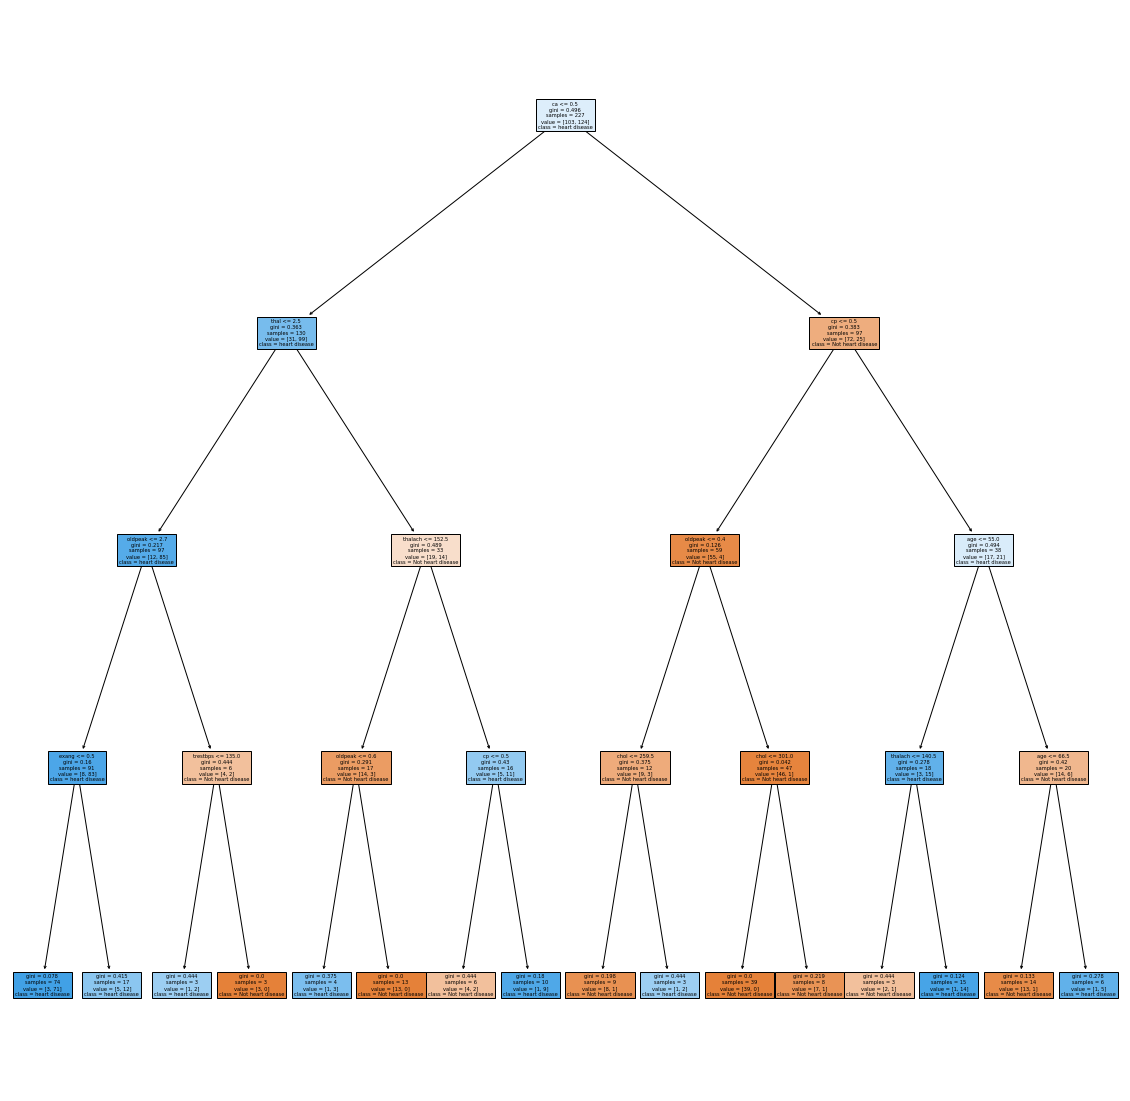

In [72]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(model,
               feature_names=features,
               class_names=classes,
               filled=True)
plt.show()

## **2. Post-Pruning Techniques**

In [73]:
path = clf.cost_complexity_pruning_path(x_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(ccp_alphas)

[0.         0.00396476 0.00431156 0.00440529 0.00587372 0.00587372
 0.00587372 0.00611872 0.0061674  0.00660793 0.00734214 0.00807636
 0.00818125 0.00845339 0.0088913  0.01117841 0.01515937 0.01661169
 0.01896491 0.02148102 0.02374217 0.04433147 0.04786917 0.1242284 ]


In [74]:
clfs = []

for ccp_alpha in ccp_alphas:
  clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf.fit(x_train, y_train)
  clfs.append(clf)

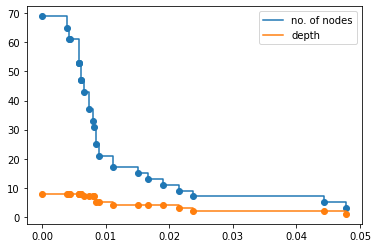

In [75]:
#We will remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.
clfs = clfs[:-1]

ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]

depth = [clf.tree_.max_depth for clf in clfs]

plt.scatter(ccp_alphas, node_counts)
plt.scatter(ccp_alphas, depth)

plt.plot(ccp_alphas, node_counts, label="no. of nodes", drawstyle="steps-post")
plt.plot(ccp_alphas, depth, label='depth', drawstyle="steps-post")

plt.legend()
plt.show()

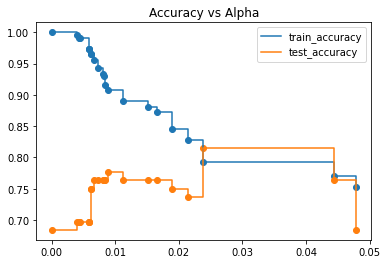

In [76]:
train_acc = []
test_acc = []

for c in clfs:
  y_train_pred = c.predict(x_train)
  y_test_pred = c.predict(x_test)
  train_acc.append(accuracy_score(y_train_pred, y_train))
  test_acc.append(accuracy_score(y_test_pred, y_test))

plt.scatter(ccp_alphas, train_acc)
plt.scatter(ccp_alphas, test_acc)

plt.plot(ccp_alphas, train_acc, label='train_accuracy', drawstyle="steps-post")
plt.plot(ccp_alphas, test_acc, label='test_accuracy', drawstyle="steps-post")

plt.legend()
plt.title("Accuracy vs Alpha")
plt.show()

Train accuracy score 0.8458149779735683
Test accuracy score 0.75

Train Confusion matrix


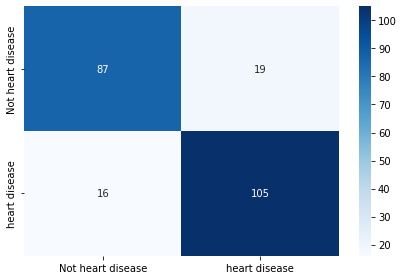


Test Confusion matrix


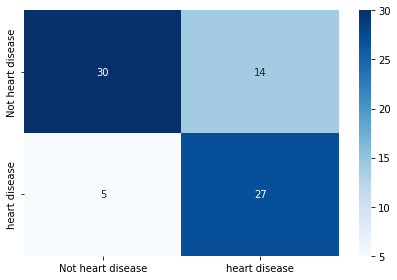

In [77]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.020)
clf_.fit(x_train,y_train)
y_train_pred = clf_.predict(x_train)
y_test_pred = clf_.predict(x_test)

print(f'Train accuracy score {accuracy_score(y_train_pred,y_train)}')
print(f'Test accuracy score {accuracy_score(y_test_pred,y_test)}')
plot_confusion_matrix(y_train_pred,y_train,dom='Train')
plot_confusion_matrix(y_test_pred,y_test,dom='Test')

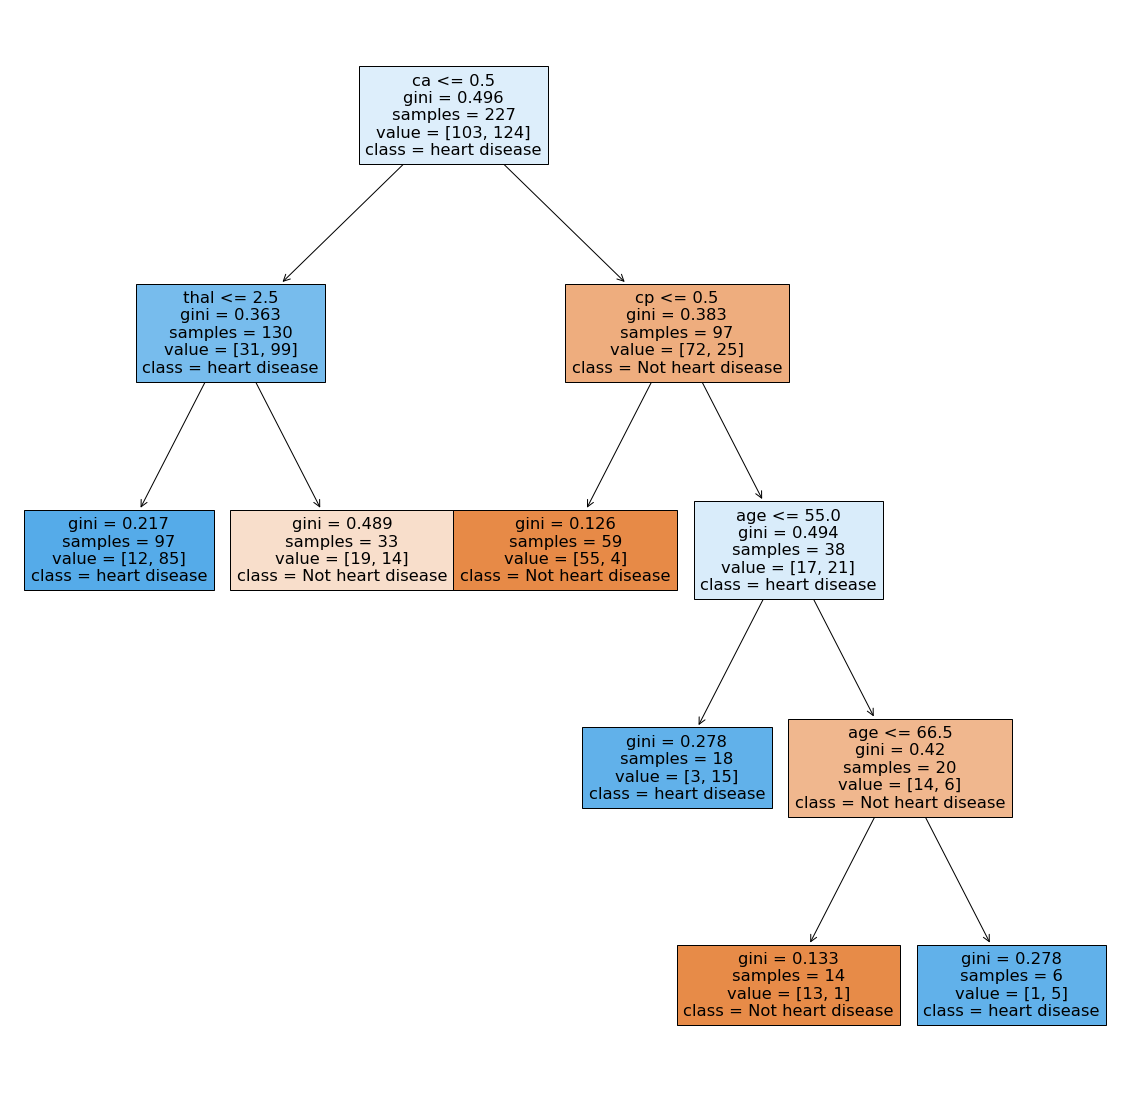

In [78]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(clf_,feature_names=features,class_names=classes,filled=True)
plt.show()